In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    training = tf.placeholder(tf.bool, [], name='training')
    return states, actions, targetQs, rates, training

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates, training):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, training=training)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, training=training)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, training=training, 
                        reuse=True)
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates, self.training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            rates=self.rates, training=self.training) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                                          model.training: False})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states, 
                                                                   model.training: False})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA], #, model.d_optQ
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates, 
                                                                   model.training: True})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:19.0000 R:19.0000 rate:0.0380 gloss:1.1612 dlossA:1.5999 dlossQ:2.0027 exploreP:0.9981
Episode:1 meanR:18.5000 R:18.0000 rate:0.0360 gloss:1.0856 dlossA:1.5922 dlossQ:1.9747 exploreP:0.9963
Episode:2 meanR:19.3333 R:21.0000 rate:0.0420 gloss:0.9642 dlossA:1.5841 dlossQ:1.6180 exploreP:0.9943
Episode:3 meanR:19.7500 R:21.0000 rate:0.0420 gloss:0.9496 dlossA:1.5736 dlossQ:1.4811 exploreP:0.9922
Episode:4 meanR:19.2000 R:17.0000 rate:0.0340 gloss:0.9916 dlossA:1.5798 dlossQ:1.9205 exploreP:0.9905
Episode:5 meanR:21.5000 R:33.0000 rate:0.0660 gloss:0.9206 dlossA:1.5661 dlossQ:1.6730 exploreP:0.9873
Episode:6 meanR:19.8571 R:10.0000 rate:0.0200 gloss:1.2101 dlossA:1.5540 dlossQ:2.5387 exploreP:0.9863
Episode:7 meanR:19.0000 R:13.0000 rate:0.0260 gloss:1.1193 dlossA:1.5466 dlossQ:2.4177 exploreP:0.9851
Episode:8 meanR:18.7778 R:17.0000 rate:0.0340 gloss:1.0153 dlossA:1.5374 dlossQ:1.8833 exploreP:0.9834
Episode:9 meanR:17.8000 R:9.0000 rate:0.0180 gloss:1.2671 dlossA:1.5286 d

Episode:79 meanR:27.2000 R:27.0000 rate:0.0540 gloss:0.4681 dlossA:1.3492 dlossQ:2.2589 exploreP:0.8064
Episode:80 meanR:27.2593 R:32.0000 rate:0.0640 gloss:0.4466 dlossA:1.3436 dlossQ:2.2300 exploreP:0.8039
Episode:81 meanR:27.3049 R:31.0000 rate:0.0620 gloss:0.4221 dlossA:1.3459 dlossQ:2.1710 exploreP:0.8014
Episode:82 meanR:27.2892 R:26.0000 rate:0.0520 gloss:0.3877 dlossA:1.3449 dlossQ:2.0826 exploreP:0.7993
Episode:83 meanR:27.2024 R:20.0000 rate:0.0400 gloss:0.4537 dlossA:1.3485 dlossQ:2.3253 exploreP:0.7978
Episode:84 meanR:27.0941 R:18.0000 rate:0.0360 gloss:0.4627 dlossA:1.3514 dlossQ:2.3248 exploreP:0.7964
Episode:85 meanR:27.0930 R:27.0000 rate:0.0540 gloss:0.4370 dlossA:1.3428 dlossQ:2.1606 exploreP:0.7942
Episode:86 meanR:27.0805 R:26.0000 rate:0.0520 gloss:0.4428 dlossA:1.3460 dlossQ:2.2262 exploreP:0.7922
Episode:87 meanR:26.9318 R:14.0000 rate:0.0280 gloss:0.4328 dlossA:1.3441 dlossQ:2.1368 exploreP:0.7911
Episode:88 meanR:27.0337 R:36.0000 rate:0.0720 gloss:0.4245 dlos

Episode:158 meanR:41.5700 R:58.0000 rate:0.1160 gloss:0.3349 dlossA:1.3224 dlossQ:2.1264 exploreP:0.5794
Episode:159 meanR:42.5600 R:114.0000 rate:0.2280 gloss:0.3204 dlossA:1.3212 dlossQ:2.0627 exploreP:0.5729
Episode:160 meanR:42.9800 R:60.0000 rate:0.1200 gloss:0.3269 dlossA:1.3204 dlossQ:2.1055 exploreP:0.5695
Episode:161 meanR:42.8100 R:29.0000 rate:0.0580 gloss:0.3415 dlossA:1.3233 dlossQ:2.1696 exploreP:0.5679
Episode:162 meanR:43.3700 R:92.0000 rate:0.1840 gloss:0.3380 dlossA:1.3255 dlossQ:2.1346 exploreP:0.5628
Episode:163 meanR:43.9500 R:70.0000 rate:0.1400 gloss:0.3399 dlossA:1.3288 dlossQ:2.1279 exploreP:0.5589
Episode:164 meanR:45.1200 R:151.0000 rate:0.3020 gloss:0.3376 dlossA:1.3277 dlossQ:2.0927 exploreP:0.5507
Episode:165 meanR:45.6700 R:79.0000 rate:0.1580 gloss:0.3410 dlossA:1.3260 dlossQ:2.1032 exploreP:0.5465
Episode:166 meanR:46.0900 R:87.0000 rate:0.1740 gloss:0.3360 dlossA:1.3262 dlossQ:2.1004 exploreP:0.5418
Episode:167 meanR:47.0500 R:137.0000 rate:0.2740 glos

Episode:236 meanR:219.3600 R:500.0000 rate:1.0000 gloss:0.5852 dlossA:1.3869 dlossQ:1.9154 exploreP:0.0818
Episode:237 meanR:223.3100 R:500.0000 rate:1.0000 gloss:0.5893 dlossA:1.3866 dlossQ:1.9052 exploreP:0.0783
Episode:238 meanR:226.7400 R:366.0000 rate:0.7320 gloss:0.6025 dlossA:1.3863 dlossQ:1.9456 exploreP:0.0759
Episode:239 meanR:231.5800 R:500.0000 rate:1.0000 gloss:0.5988 dlossA:1.3861 dlossQ:1.9259 exploreP:0.0726
Episode:240 meanR:235.9100 R:500.0000 rate:1.0000 gloss:0.6030 dlossA:1.3857 dlossQ:1.9234 exploreP:0.0696
Episode:241 meanR:240.6600 R:500.0000 rate:1.0000 gloss:0.6098 dlossA:1.3842 dlossQ:1.9109 exploreP:0.0667
Episode:242 meanR:244.7400 R:458.0000 rate:0.9160 gloss:0.6305 dlossA:1.3841 dlossQ:1.9471 exploreP:0.0641
Episode:243 meanR:249.5500 R:500.0000 rate:1.0000 gloss:0.6381 dlossA:1.3827 dlossQ:1.9227 exploreP:0.0615
Episode:244 meanR:252.6100 R:327.0000 rate:0.6540 gloss:0.6492 dlossA:1.3872 dlossQ:1.9264 exploreP:0.0598
Episode:245 meanR:255.1100 R:265.0000

Episode:313 meanR:433.8900 R:500.0000 rate:1.0000 gloss:0.6938 dlossA:1.1476 dlossQ:2.2113 exploreP:0.0123
Episode:314 meanR:436.6400 R:500.0000 rate:1.0000 gloss:0.6824 dlossA:1.1441 dlossQ:2.2188 exploreP:0.0121
Episode:315 meanR:439.2000 R:500.0000 rate:1.0000 gloss:0.6857 dlossA:1.1264 dlossQ:2.3778 exploreP:0.0120
Episode:316 meanR:440.1100 R:500.0000 rate:1.0000 gloss:0.6598 dlossA:1.1188 dlossQ:2.3369 exploreP:0.0119
Episode:317 meanR:440.1100 R:500.0000 rate:1.0000 gloss:0.6559 dlossA:1.1054 dlossQ:2.4456 exploreP:0.0118
Episode:318 meanR:441.0500 R:500.0000 rate:1.0000 gloss:0.6571 dlossA:1.1240 dlossQ:2.2967 exploreP:0.0118
Episode:319 meanR:443.4200 R:500.0000 rate:1.0000 gloss:0.6471 dlossA:1.0830 dlossQ:2.5559 exploreP:0.0117
Episode:320 meanR:447.6900 R:500.0000 rate:1.0000 gloss:0.6253 dlossA:1.0991 dlossQ:2.4520 exploreP:0.0116
Episode:321 meanR:447.9700 R:500.0000 rate:1.0000 gloss:0.6142 dlossA:1.0990 dlossQ:2.5859 exploreP:0.0115
Episode:322 meanR:447.9700 R:500.0000

Episode:390 meanR:486.2900 R:500.0000 rate:1.0000 gloss:0.7451 dlossA:0.5334 dlossQ:5.4820 exploreP:0.0101
Episode:391 meanR:484.0200 R:273.0000 rate:0.5460 gloss:0.7315 dlossA:0.4743 dlossQ:5.9278 exploreP:0.0101
Episode:392 meanR:484.0200 R:500.0000 rate:1.0000 gloss:0.7706 dlossA:0.4941 dlossQ:5.8648 exploreP:0.0100
Episode:393 meanR:484.0200 R:500.0000 rate:1.0000 gloss:0.7144 dlossA:0.5343 dlossQ:6.2261 exploreP:0.0100
Episode:394 meanR:484.0200 R:500.0000 rate:1.0000 gloss:0.7464 dlossA:0.4873 dlossQ:5.8458 exploreP:0.0100
Episode:395 meanR:484.0200 R:500.0000 rate:1.0000 gloss:0.7978 dlossA:0.4703 dlossQ:6.1719 exploreP:0.0100
Episode:396 meanR:484.0200 R:500.0000 rate:1.0000 gloss:0.7648 dlossA:0.4802 dlossQ:5.8183 exploreP:0.0100
Episode:397 meanR:484.0200 R:500.0000 rate:1.0000 gloss:0.7854 dlossA:0.4260 dlossQ:6.1354 exploreP:0.0100
Episode:398 meanR:484.0200 R:500.0000 rate:1.0000 gloss:0.8096 dlossA:0.4293 dlossQ:6.0328 exploreP:0.0100
Episode:399 meanR:484.0200 R:500.0000

Episode:467 meanR:482.3400 R:500.0000 rate:1.0000 gloss:0.7696 dlossA:0.2302 dlossQ:21.0353 exploreP:0.0100
Episode:468 meanR:482.3400 R:500.0000 rate:1.0000 gloss:0.6840 dlossA:0.2571 dlossQ:19.1138 exploreP:0.0100
Episode:469 meanR:482.3400 R:500.0000 rate:1.0000 gloss:0.6508 dlossA:0.2730 dlossQ:19.0393 exploreP:0.0100
Episode:470 meanR:482.3400 R:500.0000 rate:1.0000 gloss:0.6808 dlossA:0.2359 dlossQ:18.5399 exploreP:0.0100
Episode:471 meanR:482.4000 R:500.0000 rate:1.0000 gloss:0.6814 dlossA:0.2401 dlossQ:19.5569 exploreP:0.0100
Episode:472 meanR:482.4000 R:500.0000 rate:1.0000 gloss:0.7081 dlossA:0.2228 dlossQ:18.8465 exploreP:0.0100
Episode:473 meanR:482.4000 R:500.0000 rate:1.0000 gloss:0.7101 dlossA:0.2225 dlossQ:18.6953 exploreP:0.0100
Episode:474 meanR:482.4000 R:500.0000 rate:1.0000 gloss:0.6728 dlossA:0.2271 dlossQ:17.8782 exploreP:0.0100
Episode:475 meanR:482.4000 R:500.0000 rate:1.0000 gloss:0.7140 dlossA:0.2216 dlossQ:18.1546 exploreP:0.0100
Episode:476 meanR:482.4000 R

Episode:543 meanR:460.4100 R:500.0000 rate:1.0000 gloss:0.3790 dlossA:0.3476 dlossQ:10.6139 exploreP:0.0100
Episode:544 meanR:460.4100 R:500.0000 rate:1.0000 gloss:0.3696 dlossA:0.3623 dlossQ:10.7628 exploreP:0.0100
Episode:545 meanR:460.4100 R:500.0000 rate:1.0000 gloss:0.3761 dlossA:0.3569 dlossQ:10.5009 exploreP:0.0100
Episode:546 meanR:460.4100 R:500.0000 rate:1.0000 gloss:0.3472 dlossA:0.3779 dlossQ:10.7136 exploreP:0.0100
Episode:547 meanR:464.7800 R:500.0000 rate:1.0000 gloss:0.3629 dlossA:0.3474 dlossQ:9.8599 exploreP:0.0100
Episode:548 meanR:464.7800 R:500.0000 rate:1.0000 gloss:0.3541 dlossA:0.3747 dlossQ:9.8302 exploreP:0.0100
Episode:549 meanR:464.7800 R:500.0000 rate:1.0000 gloss:0.3409 dlossA:0.3810 dlossQ:9.6178 exploreP:0.0100
Episode:550 meanR:464.7800 R:500.0000 rate:1.0000 gloss:0.3333 dlossA:0.3897 dlossQ:9.9387 exploreP:0.0100
Episode:551 meanR:464.7800 R:500.0000 rate:1.0000 gloss:0.3399 dlossA:0.3677 dlossQ:9.9865 exploreP:0.0100
Episode:552 meanR:464.7800 R:500.

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

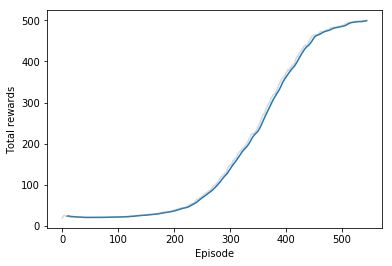

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

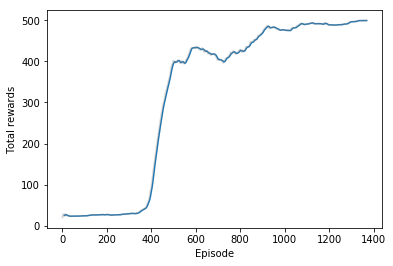

In [19]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

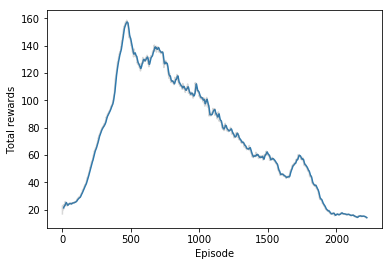

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

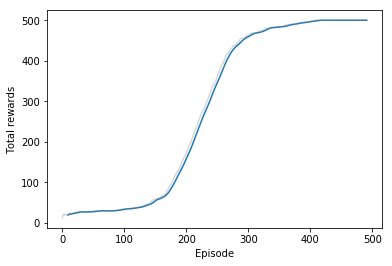

In [62]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

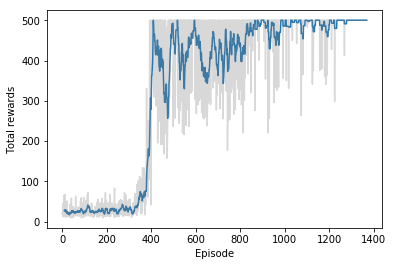

In [20]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

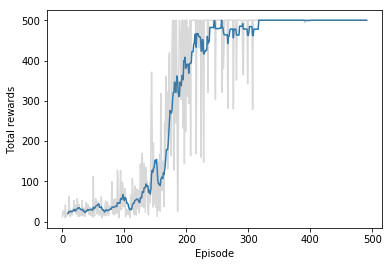

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

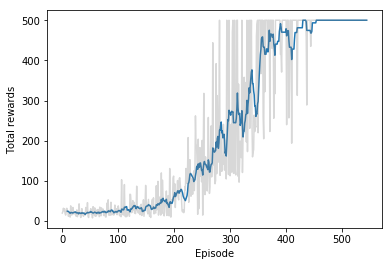

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.